# Projected where gas density is around the same in both clouds to see if average spectra look similar


### Results:
The top and bottom spectra were pretty similar overall, except for C IV. The top spectra does tend to be a little more shallow and narrower than the bottom spectra.

In [1]:
import chollaread
import yt
import trident
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/config.py:82: UserWarning: unable to create yt config directory
  warnings.warn("unable to create yt config directory")
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/config.py:127: UserWarning: unable to write new config file
  warnings.warn("unable to write new config file")
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:768: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
ds = chollaread.load('/Users/sofimar/Desktop/Summer Research/146.h5', cell_size_cgs=(10/256)*chollaread.kpc)

yt : [INFO     ] 2021-12-02 12:50:06,157 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-12-02 12:50:06,158 Parameters: domain_dimensions         = [512 256 256]
yt : [INFO     ] 2021-12-02 12:50:06,159 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-12-02 12:50:06,160 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22]
yt : [INFO     ] 2021-12-02 12:50:06,161 Parameters: cosmological_simulation   = 0.0


In [3]:
def spec_avg(x0, y0, z0, x, y, z, Nx, Nz,
             line, el, rom_num, lmin, lmax, lrest, gamma, f_value, amu,
             DIY=False, ind_p=True):
    
    # Make array of rays
    k = (3.086E+21)*10 # Code length
    cu = 1/256
    
    arrays = []
    
    
    for i in range(Nx):
        for j in range(Nz):
        
            ray_start = np.array([x0+(i*cu),y0,z0+(j*cu)])*k
            ray_end = np.array([x+(i*cu),y,z+(j*cu)])*k

            ray = trident.make_simple_ray(ds,
                                         start_position=ray_start,
                                         end_position=ray_end,
                                         data_filename= 'ray.h5',
                                         lines='all',
                                         ftype='gas')



            sg = trident.SpectrumGenerator(lambda_min= lmin, lambda_max= lmax, dlambda=0.01)
            
            if DIY==False:
            
                sg.make_spectrum(ray, lines=[line])
                sg.save_spectrum('spec.txt')
                
            else:
                sg.add_line_to_database(el, rom_num, lrest, gamma,f_value, field=None, identifier=line)

                sg.make_spectrum(ray, lines=[line])
                sg.save_spectrum('spec.txt')

            f = np.loadtxt('spec.txt')
            lam = f[:,0] # All rows, 1st column
            flux = f[:,2]

            tog = np.array([lam, flux])
            arrays.append(tog)
        
  
    
    # Average Flux
    flux_list = []
    avg = []

    for n in range(Nx*Nz): # N = Nx * Nz     
        flux_ = arrays[n][1]
        flux_list.append(flux_) # Append flux to a list
        flux_arr = np.array(flux_list) # Turn list into an array
        flux_a = flux_arr.T # Transpose array
        
    for m in range(len(flux_a)):
        avg_ = np.average(flux_a[m])
        avg.append(avg_)
        
    fig = plt.figure(figsize=(15, 5))
    
    if ind_p==True:
        for p in range(Nx*Nz):
            plt.plot(arrays[0][0], arrays[p][1], alpha=0.5)
    else:
        pass
    plt.plot(arrays[0][0], avg, color='black', label = "Average Spectrum", linewidth=1.75)
    plt.xlim(lmin, lmax)
    plt.title(line)
    plt.legend(fontsize='large')
    plt.xlabel('Wavelength')
    plt.ylabel('Relative Flux')
    
    return arrays[0][0], avg
    

In [4]:
def make_ray(x0, y0, z0, x, y, z):
    
    k = (3.086E+21)*10 # Code length
    
    ray_start = np.array([x0,y0,z0])*k
    ray_end = np.array([x,y,z])*k
    
    ray = trident.make_simple_ray(ds,
                                 start_position=ray_start,
                                 end_position=ray_end,
                                 data_filename= 'ray_.h5',
                                 lines='all',
                                 ftype='gas')
    return ray

In [5]:
def slicep(direction):

    sl = yt.SlicePlot(ds, direction, [("density")])
    sl.annotate_ray(ray_, arrow=True)
    sl.annotate_ray(ray_2, arrow=True)
    sl.annotate_ray(ray_3, arrow=True)
    sl.annotate_ray(ray_4, arrow=True)
    sl.set_cmap(("density"), "BLUE-RED")

    sl.show()

In [6]:
def proj(direction, a, b, a2, b2, a3, b3, a4, b4):
    
    px = yt.ProjectionPlot(ds, direction, 'density')
    px.annotate_marker((a,b), coord_system="plot", plot_args={"color":"dimgrey", "s": 150})
    px.annotate_marker((a2,b2), coord_system="plot", plot_args={"color":"black", "s": 150})
    px.annotate_marker((a3,b3), coord_system="plot", plot_args={"color":"dimgrey", "s": 150})
    px.annotate_marker((a4,b4), coord_system="plot", plot_args={"color":"black", "s": 150})
    px.show()

In [7]:
def compare(top_wav, top_flux, bot_wav, bot_flux, line):
    
    plt.figure(figsize=(15,5))

    plt.plot(top_wav, top_flux, label='Top', color='deeppink')
    plt.plot(bot_wav, bot_flux, label='Bottom', color='black')
    plt.title('Average Spectra:'+ line, fontsize=14)
    plt.xlabel('Wavelength')
    plt.ylabel('Relative Flux')
    plt.legend(fontsize='large')

In [8]:
# Projection plot units to slice plot units
def pts_z(z):
    return(z+5)/10

def pts_x(x):
    return (x+10)/10

# Slice Plot units to projection plot units
def stp_z(z):
    return(z*10)-5

def stp_x(x):
    return (x*10)-10

# Number of iterations for a given variable
def get_N(a0, a):
    return (a-a0)*256

yt : [INFO     ] 2021-12-02 12:58:24,188 Projection completed
yt : [INFO     ] 2021-12-02 12:58:24,189 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-12-02 12:58:24,190 ylim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-12-02 12:58:24,191 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-12-02 12:58:24,192 ylim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-12-02 12:58:24,193 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fall


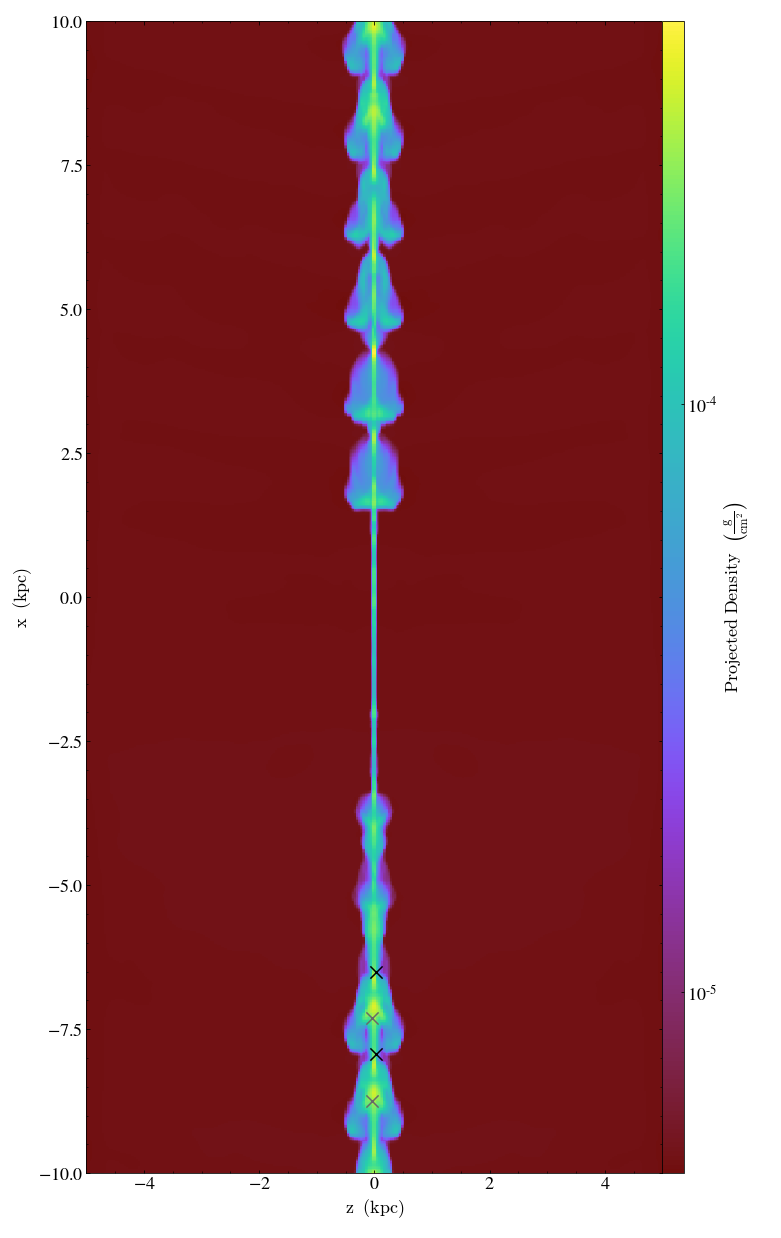

In [25]:
proj('y', -0.05,-7.3,0.02,-6.5,-0.05,-8.75,0.02,-7.93)

In [18]:
# Top Cloud
# Nx = 21
# Nz = 2
ray_ = make_ray(0.27,.618,.495,0.27,.68,.495)
ray_2 = make_ray(0.35,.618,.5028,0.35,.68,.5028)
# Bottom Cloud
# Nx = 21
# Nz = 2
ray_3 = make_ray(0.125,.27,.495,0.125,.44,.495)
ray_4 = make_ray(0.207,.27,.5028,0.207,.44,.5028)

yt : [INFO     ] 2021-12-02 12:53:52,749 Getting segment at z = 0.0: [0.135  0.309  0.2475] unitary to [0.135  0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 12:53:52,752 Getting subsegment: [0.135 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.135 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 12:53:53,780 Saving field data to yt dataset: ray_.h5.
yt : [INFO     ] 2021-12-02 12:53:53,895 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 12:53:53,896 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 12:53:53,897 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 12:53:53,898 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] 

yt : [INFO     ] 2021-12-02 12:53:59,990 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-12-02 12:53:59,990 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-12-02 12:53:59,991 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-12-02 12:53:59,992 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-12-02 12:53:59,994 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/opt/anaconda3/e


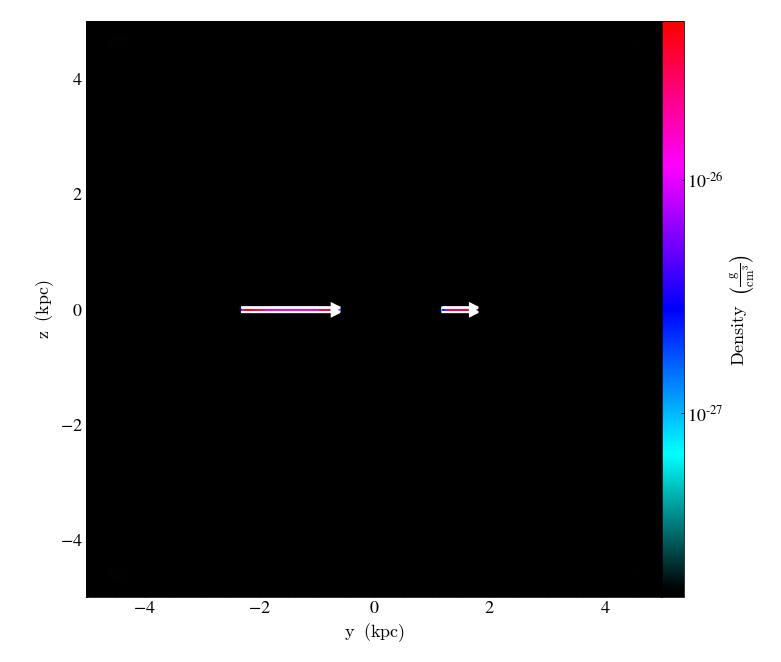

In [19]:
slicep('x')

yt : [INFO     ] 2021-12-02 12:54:00,725 xlim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-12-02 12:54:00,726 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-12-02 12:54:00,727 xlim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-12-02 12:54:00,728 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-12-02 12:54:00,729 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for


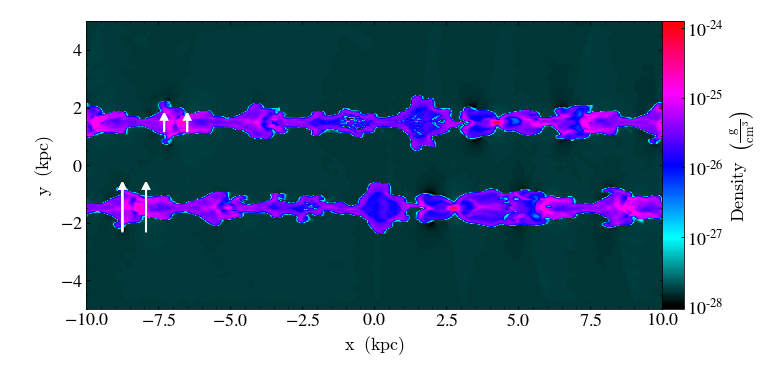

In [20]:
slicep('z')

## C IV

yt : [INFO     ] 2021-12-02 13:01:17,531 Getting segment at z = 0.0: [0.135  0.309  0.2475] unitary to [0.135  0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:01:17,533 Getting subsegment: [0.135 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.135 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:01:18,524 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:01:18,651 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:01:18,652 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:01:18,653 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:01:18,654 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] c

yt : [INFO     ] 2021-12-02 13:01:25,013 Getting segment at z = 0.0: [0.13890625 0.309      0.24945312] unitary to [0.13890625 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:01:25,015 Getting subsegment: [0.13890625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.13890625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:01:26,002 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:01:26,121 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:01:26,121 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:01:26,122 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:01:26,123 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:01:26,124 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:01:26,126 Setting instrument to Custom
yt : [INFO   

yt : [INFO     ] 2021-12-02 13:01:32,427 Getting subsegment: [0.144765625 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.144765625 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:01:33,405 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:01:33,523 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:01:33,524 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:01:33,525 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:01:33,526 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:01:33,527 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:01:33,529 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:01:33,543 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:01:33,550 Identifie

yt : [INFO     ] 2021-12-02 13:01:40,318 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:01:40,433 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:01:40,434 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:01:40,435 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:01:40,436 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:01:40,437 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:01:40,439 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:01:40,456 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:01:40,463 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:01:40,592 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:01:40,598 Creating spectrum
Addi

yt : [INFO     ] 2021-12-02 13:01:47,560 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:01:47,561 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:01:47,561 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:01:47,562 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:01:47,564 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:01:47,578 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:01:47,584 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:01:47,723 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:01:47,728 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 4074.00it/s]
yt : [INFO     ] 2021-12-02 13:01:47,792 Writing spectrum to ascii file: spec.txt.
yt : 

yt : [INFO     ] 2021-12-02 13:01:54,286 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:01:54,287 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:01:54,289 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:01:54,303 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:01:54,310 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:01:54,439 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:01:54,445 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 3886.58it/s]
yt : [INFO     ] 2021-12-02 13:01:54,509 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:01:54,530 Getting segment at z = 0.0: [0.16039063 0.309      0.2475    ] unitary to [0.16039063 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:01:54,53

yt : [INFO     ] 2021-12-02 13:02:01,047 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:02:01,049 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:02:01,064 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:02:01,070 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:02:01,203 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:02:01,208 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 3609.92it/s]
yt : [INFO     ] 2021-12-02 13:02:01,274 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:02:01,294 Getting segment at z = 0.0: [0.16429688 0.309      0.24945312] unitary to [0.16429688 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:02:01,296 Getting subsegment: [0.16429687500000004 unitary, 0.309 unitary, 0.249453125 unitary] to [0.16429687500000004 unitary, 0.34

yt : [INFO     ] 2021-12-02 13:02:07,743 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:02:07,879 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:02:07,884 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 4043.73it/s]
yt : [INFO     ] 2021-12-02 13:02:07,946 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:02:07,966 Getting segment at z = 0.0: [0.17015625 0.309      0.2475    ] unitary to [0.17015625 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:02:07,968 Getting subsegment: [0.17015625000000004 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.17015625000000004 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:02:08,913 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:02:09,026 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:02:

yt : [INFO     ] 2021-12-02 13:02:14,544 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 3326.79it/s]
yt : [INFO     ] 2021-12-02 13:02:14,609 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:02:14,630 Getting segment at z = 0.0: [0.1740625  0.309      0.24945312] unitary to [0.1740625  0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:02:14,632 Getting subsegment: [0.1740625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.1740625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:02:15,610 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:02:15,723 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:02:15,724 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:02:15,725 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:02:15,726 Parameters: domain_

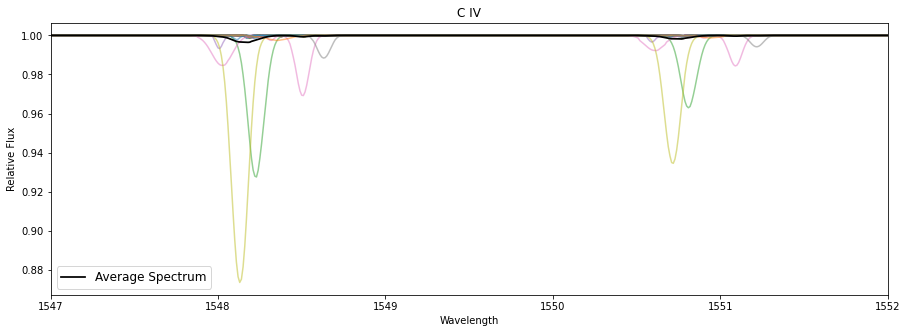

In [28]:
civ_top = spec_avg(0.27,.618,.495,0.27,.68,.495, 21, 2,
             'C IV', False, False, 1547, 1552, False, False, False, False,
             DIY=False, ind_p=True)

yt : [INFO     ] 2021-12-02 13:02:16,178 Getting segment at z = 0.0: [0.0625 0.135  0.2475] unitary to [0.0625 0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:02:16,181 Getting subsegment: [0.0625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.0625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:02:17,184 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:02:17,297 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:02:17,298 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:02:17,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:02:17,300 Parameters: domain_right_edge         = [6.172e+22 3.086

Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 3917.41it/s]
yt : [INFO     ] 2021-12-02 13:02:29,932 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:02:29,952 Getting segment at z = 0.0: [0.07226562 0.135      0.2475    ] unitary to [0.07226562 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:02:29,954 Getting subsegment: [0.072265625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.072265625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:02:30,934 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:02:31,051 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:02:31,052 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:02:31,053 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:02:31,054 Parameters: domain_right_edge         = [6.

Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 4110.69it/s]
yt : [INFO     ] 2021-12-02 13:02:43,899 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:02:43,917 Getting segment at z = 0.0: [0.08203125 0.135      0.2475    ] unitary to [0.08203125 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:02:43,920 Getting subsegment: [0.08203125 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.08203125 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:02:44,884 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:02:45,001 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:02:45,001 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:02:45,002 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:02:45,003 Parameters: domain_right_edge         = [6.17

Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 4038.90it/s]
yt : [INFO     ] 2021-12-02 13:02:57,831 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:02:57,850 Getting segment at z = 0.0: [0.09179688 0.135      0.2475    ] unitary to [0.09179688 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:02:57,853 Getting subsegment: [0.09179687500000001 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.09179687500000001 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:02:58,814 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:02:58,937 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:02:58,939 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:02:58,939 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:02:58,941 Parameters: domain_right_ed

Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 4089.19it/s]
yt : [INFO     ] 2021-12-02 13:03:11,719 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:03:11,739 Getting segment at z = 0.0: [0.1015625 0.135     0.2475   ] unitary to [0.1015625 0.22      0.2475   ] unitary.
yt : [INFO     ] 2021-12-02 13:03:11,741 Getting subsegment: [0.1015625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.1015625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:03:12,723 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:03:12,843 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:03:12,844 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:03:12,845 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:03:12,846 Parameters: domain_right_edge         = [6.172e+22 3.

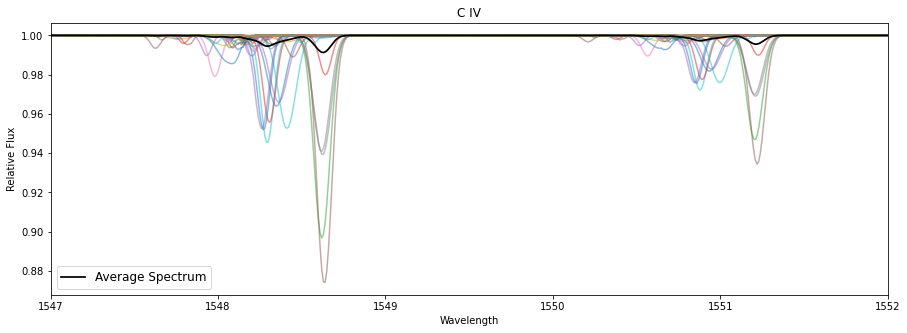

In [29]:
civ_bot = spec_avg(0.125,.27,.495,0.125,.44,.495, 21, 2,
             'C IV', False, False, 1547, 1552, False, False, False, False,
             DIY=False, ind_p=True)

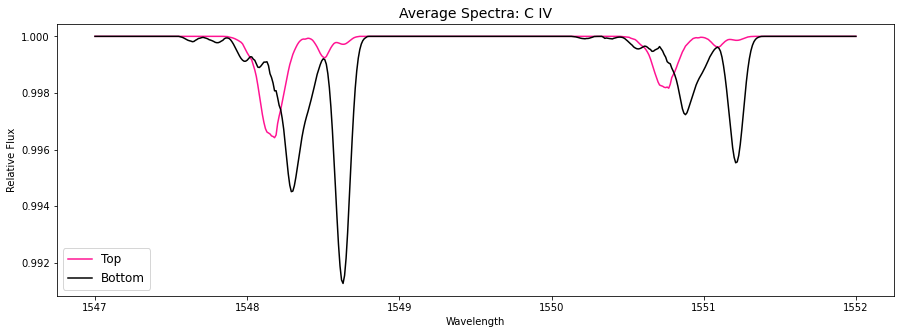

In [30]:
compare(civ_top[0], civ_top[1], civ_bot[0], civ_bot[1], ' C IV')

## Ly a

yt : [INFO     ] 2021-12-02 13:06:49,447 Getting segment at z = 0.0: [0.135  0.309  0.2475] unitary to [0.135  0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:06:49,450 Getting subsegment: [0.135 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.135 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:06:50,524 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:06:50,682 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:06:50,683 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:06:50,683 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:06:50,684 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] c

yt : [INFO     ] 2021-12-02 13:06:58,116 Getting segment at z = 0.0: [0.13890625 0.309      0.24945312] unitary to [0.13890625 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:06:58,118 Getting subsegment: [0.13890625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.13890625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:06:59,116 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:06:59,242 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:06:59,243 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:06:59,243 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:06:59,244 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:06:59,245 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:06:59,247 Setting instrument to Custom
yt : [INFO   

yt : [INFO     ] 2021-12-02 13:07:06,554 Getting subsegment: [0.144765625 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.144765625 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:07:07,596 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:07:07,715 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:07:07,716 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:07:07,717 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:07:07,718 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:07:07,718 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:07:07,721 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:07:07,735 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:07:07,743 Identifie

yt : [INFO     ] 2021-12-02 13:07:15,358 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:07:15,472 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:07:15,473 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:07:15,474 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:07:15,475 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:07:15,476 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:07:15,478 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:07:15,493 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:07:15,500 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:07:15,630 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:07:15,637 Creating spectrum
Adding 

yt : [INFO     ] 2021-12-02 13:07:22,994 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:07:22,995 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:07:22,996 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:07:22,997 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:07:23,000 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:07:23,014 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:07:23,020 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:07:23,154 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:07:23,162 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 159.35it/s]
yt : [INFO     ] 2021-12-02 13:07:23,319 Not adding continuum Ly C: insufficient column density o

yt : [INFO     ] 2021-12-02 13:07:30,400 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:07:30,400 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:07:30,401 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:07:30,404 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:07:30,418 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:07:30,424 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:07:30,558 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:07:30,565 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 125.09it/s]
yt : [INFO     ] 2021-12-02 13:07:30,754 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-12-02 13:07:30,755 Writing spectrum to ascii file: s

yt : [INFO     ] 2021-12-02 13:07:38,100 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:07:38,100 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:07:38,103 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:07:38,118 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:07:38,124 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:07:38,260 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:07:38,267 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 134.21it/s]
yt : [INFO     ] 2021-12-02 13:07:38,452 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-12-02 13:07:38,453 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:07:38,511 Getting segment at z = 0.0: [0.16429688 0.309      0.2

yt : [INFO     ] 2021-12-02 13:07:45,783 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:07:45,785 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:07:45,799 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:07:45,804 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:07:45,937 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:07:45,944 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 89.42it/s]
yt : [INFO     ] 2021-12-02 13:07:46,187 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-12-02 13:07:46,188 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:07:46,245 Getting segment at z = 0.0: [0.17015625 0.309      0.2475    ] unitary to [0.17015625 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:07:46,247 Getting subsegment: [

yt : [INFO     ] 2021-12-02 13:07:53,420 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:07:53,435 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:07:53,441 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:07:53,572 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:07:53,579 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 205.13it/s]
yt : [INFO     ] 2021-12-02 13:07:53,714 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-12-02 13:07:53,715 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:07:53,771 Getting segment at z = 0.0: [0.1740625  0.309      0.24945312] unitary to [0.1740625  0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:07:53,772 Getting subsegment: [0.1740625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.1740625 unitary, 0.34 u

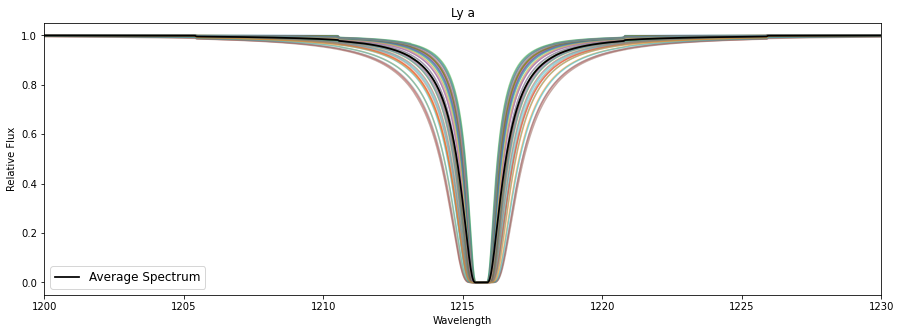

In [31]:
lya_top = spec_avg(.27,.618,.495,.27,.68,.495, 21, 2,
             'Ly a', False, False, 1200, 1230, False, False, False, False,
             DIY=False, ind_p=True)

yt : [INFO     ] 2021-12-02 13:07:55,696 Getting segment at z = 0.0: [0.0625 0.135  0.2475] unitary to [0.0625 0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:07:55,699 Getting subsegment: [0.0625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.0625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:07:56,663 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:07:56,796 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:07:56,797 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:07:56,797 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:07:56,799 Parameters: domain_right_edge         = [6.172e+22 3.086

yt : [INFO     ] 2021-12-02 13:08:03,896 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:08:03,953 Getting segment at z = 0.0: [0.06640625 0.135      0.24945312] unitary to [0.06640625 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:08:03,955 Getting subsegment: [0.06640625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.06640625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:08:04,903 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:08:05,022 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:08:05,022 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:08:05,023 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:08:05,024 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:08:05,025 Parameters: cosmological_simu

yt : [INFO     ] 2021-12-02 13:08:12,225 Getting segment at z = 0.0: [0.07226562 0.135      0.2475    ] unitary to [0.07226562 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:08:12,227 Getting subsegment: [0.072265625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.072265625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:08:13,163 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:08:13,277 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:08:13,278 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:08:13,279 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:08:13,280 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:08:13,281 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:08:13,283 Setting i

yt : [INFO     ] 2021-12-02 13:08:20,216 Getting subsegment: [0.076171875 unitary, 0.135 unitary, 0.249453125 unitary] to [0.076171875 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:08:21,189 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:08:21,304 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:08:21,305 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:08:21,305 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:08:21,306 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:08:21,307 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:08:21,309 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:08:21,324 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:08:21,331 Identified

yt : [INFO     ] 2021-12-02 13:08:29,112 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:08:29,230 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:08:29,231 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:08:29,231 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:08:29,232 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:08:29,233 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:08:29,235 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:08:29,252 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:08:29,260 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:08:29,388 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:08:29,396 Creating spectrum
Adding 

yt : [INFO     ] 2021-12-02 13:08:36,894 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:08:37,039 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:08:37,041 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:08:37,042 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:08:37,043 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:08:37,043 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:08:37,046 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:08:37,060 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:08:37,067 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:08:37,268 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:08:37,275 Creating spectrum
Adding 

yt : [INFO     ] 2021-12-02 13:08:44,800 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:08:44,916 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:08:44,917 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:08:44,917 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:08:44,918 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:08:44,919 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:08:44,921 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:08:44,937 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:08:44,945 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:08:45,074 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:08:45,081 Creating spectrum
Adding 

yt : [INFO     ] 2021-12-02 13:08:52,714 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:08:52,715 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:08:52,716 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:08:52,717 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:08:52,718 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:08:52,720 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:08:52,735 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:08:52,743 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:08:52,876 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:08:52,884 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 44/44 [00:00<00:00, 229.72it/s]
yt

yt : [INFO     ] 2021-12-02 13:09:00,390 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:09:00,391 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:09:00,391 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:09:00,392 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:09:00,393 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:09:00,395 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:09:00,412 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:09:00,419 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:09:00,554 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:09:00,561 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 44/44 [00:00<00:00, 561.13it/s]
yt

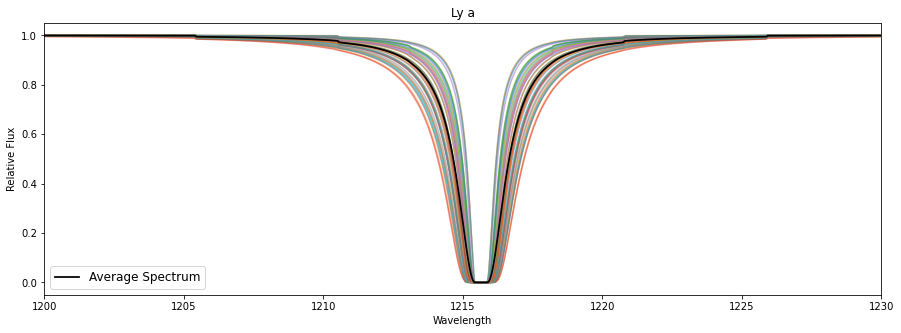

In [32]:
lya_bottom = spec_avg(.125,.27,.495,.125,.44,.495, 21, 2,
             'Ly a', False, False, 1200, 1230, False, False, False, False,
             DIY=False, ind_p=True)

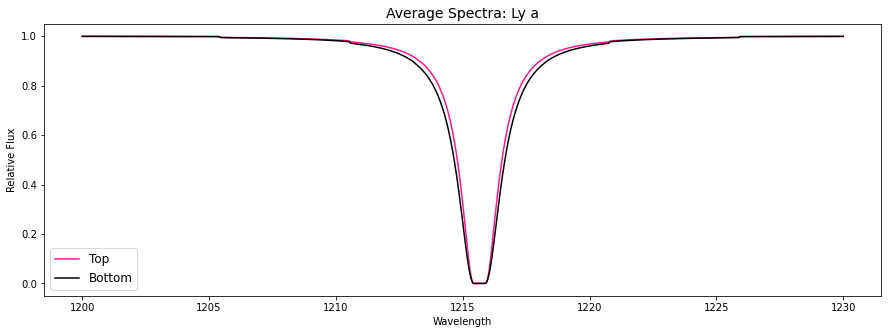

In [33]:
compare(lya_top[0], lya_top[1], lya_bottom[0], lya_bottom[1], ' Ly a')

## O I 1302

yt : [INFO     ] 2021-12-02 13:10:17,438 Getting segment at z = 0.0: [0.135  0.309  0.2475] unitary to [0.135  0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:10:17,441 Getting subsegment: [0.135 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.135 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:10:18,675 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:10:18,830 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:10:18,831 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:10:18,831 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:10:18,832 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] c

yt : [INFO     ] 2021-12-02 13:10:26,450 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:10:26,450 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:10:26,451 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:10:26,452 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:10:26,454 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:10:26,468 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:10:26,474 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:10:26,603 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:10:26,609 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1281.83it/s]
yt : [INFO     ] 2021-12-02 13:10:26,674 Writing spectrum to ascii file: spec.txt.
yt : [INF

yt : [INFO     ] 2021-12-02 13:10:34,528 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:10:34,534 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1224.09it/s]
yt : [INFO     ] 2021-12-02 13:10:34,606 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:10:34,621 Getting segment at z = 0.0: [0.14476563 0.309      0.24945312] unitary to [0.14476563 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:10:34,624 Getting subsegment: [0.144765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.144765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:10:35,655 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:10:35,783 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:10:35,784 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:10:35,785 Paramet

yt : [INFO     ] 2021-12-02 13:10:43,202 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:10:43,361 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:10:43,362 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:10:43,363 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:10:43,363 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:10:43,364 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:10:43,367 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:10:43,385 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:10:43,392 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:10:43,554 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:10:43,561 Creating spectrum
Adding 

yt : [INFO     ] 2021-12-02 13:10:50,459 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:10:50,465 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:10:50,599 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:10:50,605 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1277.03it/s]
yt : [INFO     ] 2021-12-02 13:10:50,670 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:10:50,687 Getting segment at z = 0.0: [0.15648438 0.309      0.2475    ] unitary to [0.15648438 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:10:50,689 Getting subsegment: [0.156484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.156484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:10:51,673 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:10:51,790 Para

yt : [INFO     ] 2021-12-02 13:10:57,769 Getting subsegment: [0.160390625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.160390625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:10:58,736 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:10:58,851 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:10:58,852 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:10:58,853 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:10:58,854 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:10:58,855 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:10:58,858 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:10:58,874 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:10:58,881 Identified 2.500e+01 octs

yt : [INFO     ] 2021-12-02 13:11:05,540 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:11:05,542 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:11:05,560 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:11:05,565 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:11:05,796 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:11:05,804 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1449.05it/s]
yt : [INFO     ] 2021-12-02 13:11:05,868 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:11:05,883 Getting segment at z = 0.0: [0.16625    0.309      0.24945312] unitary to [0.16625    0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:11:05,885 Getting subsegment: [0.16625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.16625 unitary, 0.34 unitary, 0.249453125 unitar

yt : [INFO     ] 2021-12-02 13:11:12,647 Getting segment at z = 0.0: [0.17210938 0.309      0.2475    ] unitary to [0.17210938 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:11:12,649 Getting subsegment: [0.172109375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.172109375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:11:13,612 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:11:13,729 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:11:13,730 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:11:13,731 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:11:13,732 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:11:13,733 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:11:13,735 Setting instrument to Cu

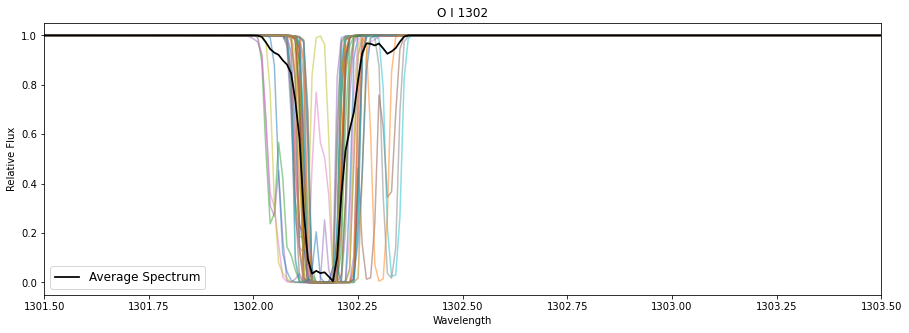

In [34]:
oi1302_t = spec_avg(.27,.618,.495,.27,.68,.495, 21, 2,
                   'O I 1302', False, False, 1301.5, 1303.5,
                   False, False, False, False, DIY=False, ind_p=True)

yt : [INFO     ] 2021-12-02 13:11:18,830 Getting segment at z = 0.0: [0.0625 0.135  0.2475] unitary to [0.0625 0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:11:18,832 Getting subsegment: [0.0625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.0625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:11:19,934 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:11:20,103 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:11:20,104 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:11:20,105 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:11:20,106 Parameters: domain_right_edge         = [6.172e+22 3.086

yt : [INFO     ] 2021-12-02 13:11:27,980 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:11:27,981 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:11:27,981 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:11:27,982 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:11:27,983 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:11:27,985 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:11:28,000 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:11:28,009 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:11:28,148 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:11:28,153 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1892.70it/

yt : [INFO     ] 2021-12-02 13:11:34,851 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:11:34,856 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:11:34,987 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:11:34,992 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2193.20it/s]
yt : [INFO     ] 2021-12-02 13:11:35,064 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:11:35,079 Getting segment at z = 0.0: [0.07226562 0.135      0.24945312] unitary to [0.07226562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:11:35,081 Getting subsegment: [0.072265625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.072265625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:11:36,065 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:11:36,180 Param

yt : [INFO     ] 2021-12-02 13:11:41,835 Getting subsegment: [0.078125 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.078125 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:11:42,807 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:11:42,921 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:11:42,922 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:11:42,923 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:11:42,924 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:11:42,925 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:11:42,928 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:11:42,944 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:11:42,952 

yt : [INFO     ] 2021-12-02 13:11:49,798 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:11:49,801 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:11:49,804 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:11:49,819 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:11:49,824 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:11:49,951 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:11:49,957 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2369.15it/s]
yt : [INFO     ] 2021-12-02 13:11:50,031 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:11:50,047 Getting segment at z = 0.0: [0.08398438 0.135      0.2475    ] unitary to [0.08398438 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:11:50,049 Ge

yt : [INFO     ] 2021-12-02 13:11:56,890 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2248.55it/s]
yt : [INFO     ] 2021-12-02 13:11:56,963 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:11:56,978 Getting segment at z = 0.0: [0.08789062 0.135      0.24945312] unitary to [0.08789062 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:11:56,982 Getting subsegment: [0.087890625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.087890625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:11:57,967 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:11:58,082 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:11:58,083 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:11:58,084 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:11:58,085 P

yt : [INFO     ] 2021-12-02 13:12:04,956 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:12:05,070 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:12:05,071 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:12:05,072 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:12:05,073 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:12:05,074 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:12:05,077 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:12:05,094 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:12:05,101 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:12:05,233 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:12:05,239 Creating spectrum
Adding 

yt : [INFO     ] 2021-12-02 13:12:12,056 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:12:12,073 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:12:12,079 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:12:12,209 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:12:12,215 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2804.36it/s]
yt : [INFO     ] 2021-12-02 13:12:12,282 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:12:12,298 Getting segment at z = 0.0: [0.09960938 0.135      0.2475    ] unitary to [0.09960938 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:12:12,300 Getting subsegment: [0.099609375 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.099609375 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:12:13,287 S

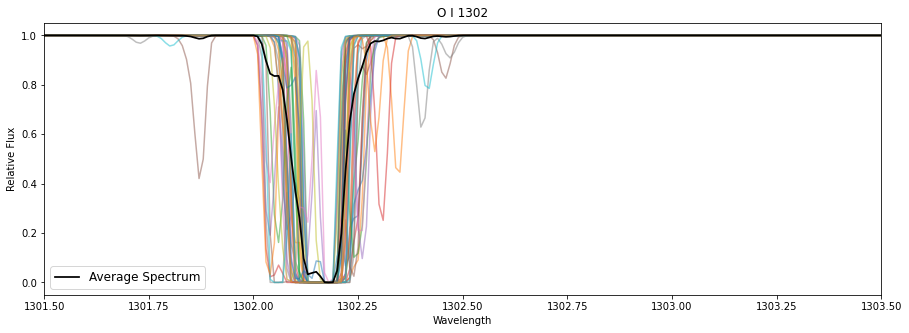

In [35]:
oi1302_b = spec_avg(.125,.27,.495,.125,.44,.495, 21, 2,
                   'O I 1302', False, False, 1301.5, 1303.5,
                   False, False, False, False, DIY=False, ind_p=True)

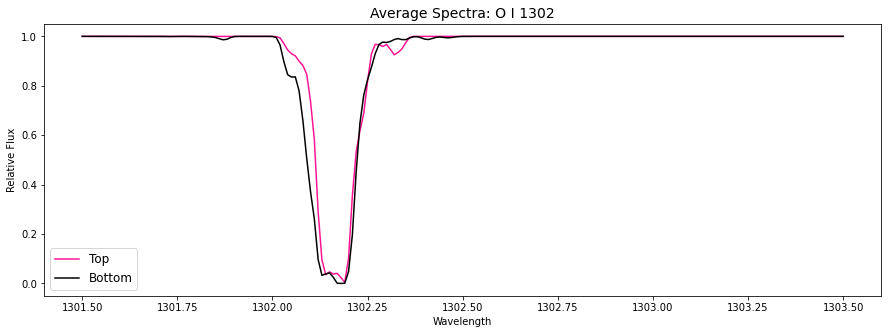

In [36]:
compare(oi1302_t[0], oi1302_t[1], oi1302_b[0], oi1302_b[1], ' O I 1302')

## Si II 1304

yt : [INFO     ] 2021-12-02 13:15:09,347 Getting segment at z = 0.0: [0.135  0.309  0.2475] unitary to [0.135  0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:15:09,350 Getting subsegment: [0.135 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.135 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:15:10,434 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:15:10,571 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:15:10,572 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:15:10,573 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:15:10,573 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] c

yt : [INFO     ] 2021-12-02 13:15:18,202 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:15:18,203 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:15:18,204 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:15:18,206 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:15:18,208 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:15:18,226 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:15:18,233 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:15:18,394 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:15:18,400 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 739.90it/s]
yt : [INFO     ] 2021-12-02 13:15:18,485 Writing spectrum to ascii file: spec.txt.
yt :

yt : [INFO     ] 2021-12-02 13:15:25,675 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:15:25,680 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 638.55it/s]
yt : [INFO     ] 2021-12-02 13:15:25,776 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:15:25,791 Getting segment at z = 0.0: [0.14476563 0.309      0.24945312] unitary to [0.14476563 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:15:25,793 Getting subsegment: [0.144765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.144765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:15:26,871 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:15:27,018 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:15:27,019 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:15:27,020 Pa

yt : [INFO     ] 2021-12-02 13:15:34,242 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:15:34,355 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:15:34,357 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:15:34,357 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:15:34,358 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:15:34,359 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:15:34,362 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:15:34,380 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:15:34,386 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:15:34,516 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:15:34,521 Creating spectrum
Add

yt : [INFO     ] 2021-12-02 13:15:41,154 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:15:41,160 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:15:41,289 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:15:41,294 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 872.73it/s]
yt : [INFO     ] 2021-12-02 13:15:41,365 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:15:41,380 Getting segment at z = 0.0: [0.15648438 0.309      0.2475    ] unitary to [0.15648438 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:15:41,382 Getting subsegment: [0.156484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.156484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:15:42,335 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:15:42,447

yt : [INFO     ] 2021-12-02 13:15:48,067 Getting subsegment: [0.160390625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.160390625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:15:49,026 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:15:49,136 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:15:49,137 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:15:49,137 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:15:49,138 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:15:49,139 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:15:49,141 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:15:49,157 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:15:49,164 Identified 2.500e+01 octs

yt : [INFO     ] 2021-12-02 13:15:55,959 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:15:55,961 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:15:55,976 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:15:55,982 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:15:56,117 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:15:56,122 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 977.30it/s]
yt : [INFO     ] 2021-12-02 13:15:56,189 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:15:56,204 Getting segment at z = 0.0: [0.16625    0.309      0.24945312] unitary to [0.16625    0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:15:56,206 Getting subsegment: [0.16625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.16625 unitary, 0.34 unitary, 0.249453125 u

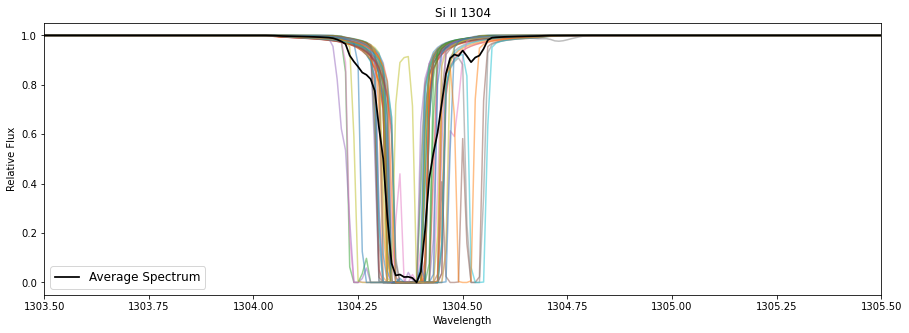

In [37]:
si1304_t = spec_avg(.27,.618,.495,.27,.68,.495, 21, 2,
                   'Si II 1304', False, False, 1303.5, 1305.5,
                   False, False, False, False, DIY=False, ind_p=True)

yt : [INFO     ] 2021-12-02 13:16:09,171 Getting segment at z = 0.0: [0.0625 0.135  0.2475] unitary to [0.0625 0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:16:09,174 Getting subsegment: [0.0625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.0625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:16:10,184 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:16:10,310 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:16:10,312 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:16:10,312 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:16:10,313 Parameters: domain_right_edge         = [6.172e+22 3.086

yt : [INFO     ] 2021-12-02 13:16:17,323 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:16:17,324 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:16:17,325 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:16:17,326 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:16:17,327 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:16:17,329 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:16:17,343 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:16:17,351 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:16:17,482 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:16:17,490 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1141

yt : [INFO     ] 2021-12-02 13:16:24,203 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:16:24,208 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:16:24,340 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:16:24,345 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1261.82it/s]
yt : [INFO     ] 2021-12-02 13:16:24,431 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:16:24,447 Getting segment at z = 0.0: [0.07226562 0.135      0.24945312] unitary to [0.07226562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:16:24,449 Getting subsegment: [0.072265625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.072265625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:16:25,434 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:16:25,552

yt : [INFO     ] 2021-12-02 13:16:31,376 Getting subsegment: [0.078125 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.078125 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:16:32,351 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:16:32,470 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:16:32,471 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:16:32,472 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:16:32,473 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:16:32,474 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:16:32,476 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:16:32,497 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:16:32,504 

yt : [INFO     ] 2021-12-02 13:16:39,424 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:16:39,425 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:16:39,427 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:16:39,442 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:16:39,448 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:16:39,580 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:16:39,584 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1500.57it/s]
yt : [INFO     ] 2021-12-02 13:16:39,670 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:16:39,686 Getting segment at z = 0.0: [0.08398438 0.135      0.2475    ] unitary to [0.08398438 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:16:39,

yt : [INFO     ] 2021-12-02 13:16:46,568 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1577.84it/s]
yt : [INFO     ] 2021-12-02 13:16:46,646 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:16:46,663 Getting segment at z = 0.0: [0.08789062 0.135      0.24945312] unitary to [0.08789062 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:16:46,665 Getting subsegment: [0.087890625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.087890625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:16:47,656 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:16:47,768 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:16:47,768 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:16:47,769 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:16:47,770

yt : [INFO     ] 2021-12-02 13:16:54,416 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:16:54,531 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:16:54,532 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:16:54,533 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:16:54,533 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:16:54,534 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:16:54,538 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:16:54,556 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:16:54,564 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:16:54,692 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:16:54,697 Creating spectrum
Add

yt : [INFO     ] 2021-12-02 13:17:01,477 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:17:01,492 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:17:01,497 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:17:01,642 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:17:01,648 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1775.62it/s]
yt : [INFO     ] 2021-12-02 13:17:01,728 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:17:01,743 Getting segment at z = 0.0: [0.09960938 0.135      0.2475    ] unitary to [0.09960938 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:17:01,746 Getting subsegment: [0.099609375 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.099609375 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:17:02

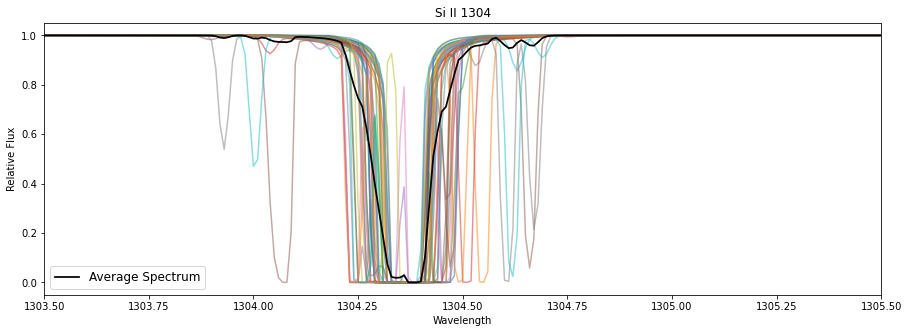

In [38]:
si1304_b = spec_avg(.125,.27,.495,.125,.44,.495, 21, 2,
                   'Si II 1304', False, False, 1303.5, 1305.5,
                   False, False, False, False, DIY=False, ind_p=True)

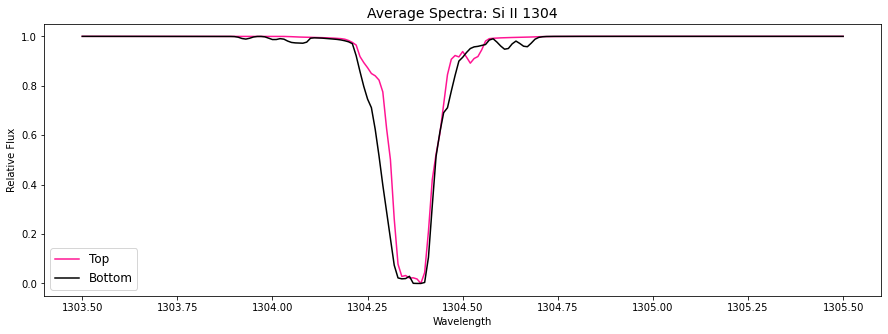

In [39]:
compare(si1304_t[0], si1304_t[1], si1304_b[0], si1304_b[1], ' Si II 1304')

## C II 1335

yt : [INFO     ] 2021-12-02 13:18:19,992 Getting segment at z = 0.0: [0.135  0.309  0.2475] unitary to [0.135  0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:18:19,996 Getting subsegment: [0.135 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.135 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:18:21,019 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:18:21,169 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:18:21,170 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:18:21,170 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:18:21,171 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] c

yt : [INFO     ] 2021-12-02 13:18:28,807 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:18:28,807 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:18:28,808 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:18:28,809 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:18:28,811 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:18:28,825 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:18:28,833 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:18:29,014 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:18:29,022 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1090.80it/s]
yt : [INFO     ] 2021-12-02 13:18:29,109 Writing spectrum to ascii file: spec.txt.
yt : 

yt : [INFO     ] 2021-12-02 13:18:36,227 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:18:36,232 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 972.92it/s]
yt : [INFO     ] 2021-12-02 13:18:36,306 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:18:36,323 Getting segment at z = 0.0: [0.14476563 0.309      0.24945312] unitary to [0.14476563 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:18:36,325 Getting subsegment: [0.144765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.144765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:18:37,309 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:18:37,428 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:18:37,429 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:18:37,430 Para

yt : [INFO     ] 2021-12-02 13:18:44,105 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:18:44,223 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:18:44,224 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:18:44,225 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:18:44,226 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:18:44,227 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:18:44,229 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:18:44,244 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:18:44,250 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:18:44,379 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:18:44,384 Creating spectrum
Addi

yt : [INFO     ] 2021-12-02 13:18:51,067 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:18:51,072 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:18:51,203 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:18:51,209 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1368.77it/s]
yt : [INFO     ] 2021-12-02 13:18:51,272 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:18:51,287 Getting segment at z = 0.0: [0.15648438 0.309      0.2475    ] unitary to [0.15648438 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:18:51,289 Getting subsegment: [0.156484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.156484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:18:52,265 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:18:52,380 

yt : [INFO     ] 2021-12-02 13:18:58,130 Getting subsegment: [0.160390625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.160390625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:18:59,134 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:18:59,245 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:18:59,246 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:18:59,247 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:18:59,248 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:18:59,249 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:18:59,253 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:18:59,269 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:18:59,275 Identified 2.500e+01 octs

yt : [INFO     ] 2021-12-02 13:19:05,999 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:19:06,001 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:19:06,017 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:19:06,023 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:19:06,161 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:19:06,167 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1393.46it/s]
yt : [INFO     ] 2021-12-02 13:19:06,231 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:19:06,246 Getting segment at z = 0.0: [0.16625    0.309      0.24945312] unitary to [0.16625    0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:19:06,249 Getting subsegment: [0.16625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.16625 unitary, 0.34 unitary, 0.249453125 un

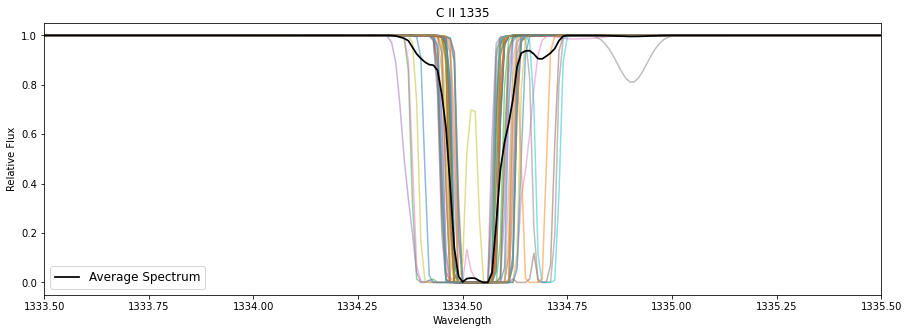

In [40]:
cii1335_t = spec_avg(.27,.618,.495,.27,.68,.495, 21, 2,
                   'C II 1335', False, False, 1333.5, 1335.5,
                   False, False, False, False, DIY=False, ind_p=True)

yt : [INFO     ] 2021-12-02 13:19:18,805 Getting segment at z = 0.0: [0.0625 0.135  0.2475] unitary to [0.0625 0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:19:18,807 Getting subsegment: [0.0625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.0625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:19:19,793 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:19:19,910 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:19:19,911 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:19:19,912 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:19:19,913 Parameters: domain_right_edge         = [6.172e+22 3.086

yt : [INFO     ] 2021-12-02 13:19:26,793 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:19:26,794 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:19:26,795 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:19:26,795 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:19:26,796 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:19:26,798 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:19:26,812 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:19:26,819 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:19:27,060 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:19:27,069 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1705.4

yt : [INFO     ] 2021-12-02 13:19:33,802 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:19:33,808 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:19:33,963 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:19:33,968 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1811.97it/s]
yt : [INFO     ] 2021-12-02 13:19:34,047 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:19:34,062 Getting segment at z = 0.0: [0.07226562 0.135      0.24945312] unitary to [0.07226562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:19:34,064 Getting subsegment: [0.072265625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.072265625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:19:35,110 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:19:35,226 P

yt : [INFO     ] 2021-12-02 13:19:41,085 Getting subsegment: [0.078125 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.078125 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:19:42,054 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:19:42,176 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:19:42,176 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:19:42,177 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:19:42,178 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:19:42,179 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:19:42,181 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:19:42,196 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:19:42,203 

yt : [INFO     ] 2021-12-02 13:19:49,118 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:19:49,119 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:19:49,121 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:19:49,135 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:19:49,140 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:19:49,273 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:19:49,281 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2160.34it/s]
yt : [INFO     ] 2021-12-02 13:19:49,355 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:19:49,370 Getting segment at z = 0.0: [0.08398438 0.135      0.2475    ] unitary to [0.08398438 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:19:49,37

yt : [INFO     ] 2021-12-02 13:19:56,254 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2204.42it/s]
yt : [INFO     ] 2021-12-02 13:19:56,326 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:19:56,342 Getting segment at z = 0.0: [0.08789062 0.135      0.24945312] unitary to [0.08789062 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:19:56,345 Getting subsegment: [0.087890625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.087890625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:19:57,326 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:19:57,443 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:19:57,443 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:19:57,444 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:19:57,445 

yt : [INFO     ] 2021-12-02 13:20:04,242 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:20:04,365 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:20:04,366 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:20:04,367 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:20:04,368 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:20:04,369 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:20:04,371 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:20:04,387 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:20:04,393 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:20:04,524 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:20:04,530 Creating spectrum
Addi

yt : [INFO     ] 2021-12-02 13:20:11,271 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:20:11,289 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:20:11,294 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:20:11,433 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:20:11,438 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2948.26it/s]
yt : [INFO     ] 2021-12-02 13:20:11,506 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:20:11,521 Getting segment at z = 0.0: [0.09960938 0.135      0.2475    ] unitary to [0.09960938 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:20:11,523 Getting subsegment: [0.099609375 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.099609375 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:20:12,4

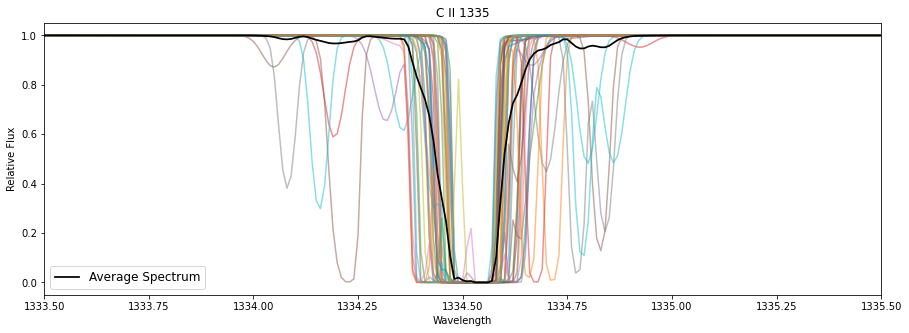

In [41]:
cii1335_b = spec_avg(.125,.27,.495,.125,.44,.495, 21, 2,
                   'C II 1335', False, False, 1333.5, 1335.5,
                   False, False, False, False, DIY=False, ind_p=True)

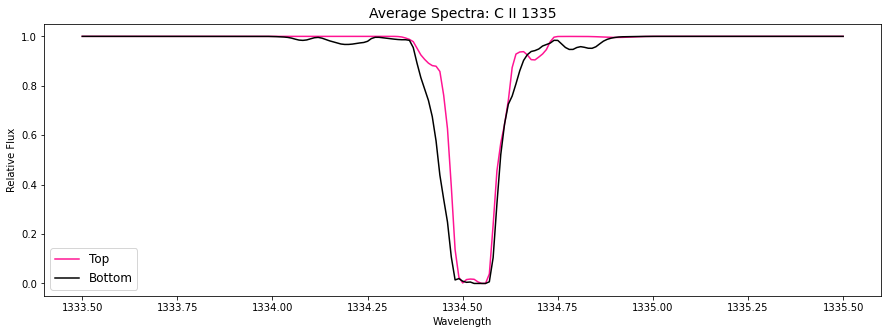

In [42]:
compare(cii1335_t[0], cii1335_t[1], cii1335_b[0], cii1335_b[1], ' C II 1335')

## Si IV 1393

yt : [INFO     ] 2021-12-02 13:21:58,557 Getting segment at z = 0.0: [0.135  0.309  0.2475] unitary to [0.135  0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:21:58,560 Getting subsegment: [0.135 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.135 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:21:59,698 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:21:59,852 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:21:59,853 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:21:59,854 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:21:59,855 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] c

yt : [INFO     ] 2021-12-02 13:22:07,656 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:22:07,657 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:22:07,658 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:22:07,659 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:22:07,661 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:22:07,676 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:22:07,682 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:22:07,824 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:22:07,829 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2141.30it/s]
yt : [INFO     ] 2021-12-02 13:22:07,890 Writing spectrum to ascii file: spec.txt.
yt 

yt : [INFO     ] 2021-12-02 13:22:15,205 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:22:15,210 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2159.52it/s]
yt : [INFO     ] 2021-12-02 13:22:15,276 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:22:15,291 Getting segment at z = 0.0: [0.14476563 0.309      0.24945312] unitary to [0.14476563 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:22:15,293 Getting subsegment: [0.144765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.144765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:22:16,330 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:22:16,447 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:22:16,448 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:22:16,449 P

yt : [INFO     ] 2021-12-02 13:22:23,560 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:22:23,677 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:22:23,678 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:22:23,679 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:22:23,679 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:22:23,680 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:22:23,683 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:22:23,697 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:22:23,705 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:22:23,967 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:22:23,975 Creating spectrum
Add

yt : [INFO     ] 2021-12-02 13:22:30,686 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:22:30,691 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:22:30,821 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:22:30,826 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1915.93it/s]
yt : [INFO     ] 2021-12-02 13:22:30,889 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:22:30,905 Getting segment at z = 0.0: [0.15648438 0.309      0.2475    ] unitary to [0.15648438 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:22:30,907 Getting subsegment: [0.156484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.156484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:22:31,881 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:22:31,99

yt : [INFO     ] 2021-12-02 13:22:38,242 Getting subsegment: [0.160390625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.160390625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:22:39,418 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:22:39,571 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:22:39,572 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:22:39,572 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:22:39,574 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:22:39,574 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:22:39,576 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:22:39,594 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:22:39,601 Identified 2.500e+01 octs

yt : [INFO     ] 2021-12-02 13:22:47,689 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:22:47,691 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:22:47,709 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:22:47,716 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:22:47,882 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:22:47,889 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1480.33it/s]
yt : [INFO     ] 2021-12-02 13:22:47,961 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:22:47,980 Getting segment at z = 0.0: [0.16625    0.309      0.24945312] unitary to [0.16625    0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:22:47,982 Getting subsegment: [0.16625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.16625 unitary, 0.34 unitary, 0.249453125 

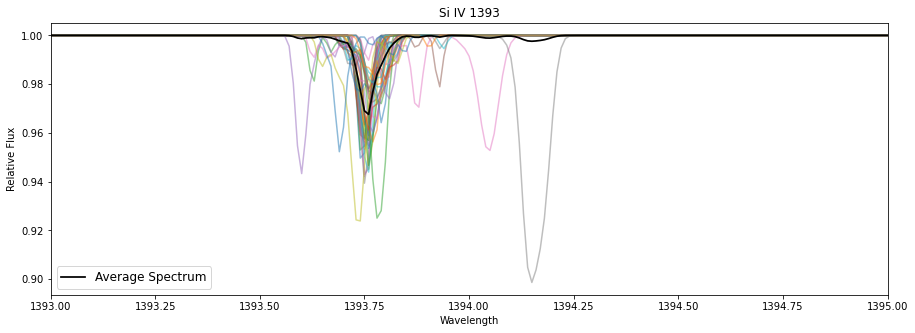

In [43]:
si1393_t = spec_avg(.27,.618,.495,.27,.68,.495, 21, 2,
                    'Si IV 1393', 'Si', 'IV', 1393, 1395, 1393.76, 9.0E+8, 5.24E-01, 28.08,
                    DIY=True, ind_p=True)

yt : [INFO     ] 2021-12-02 13:23:03,164 Getting segment at z = 0.0: [0.0625 0.135  0.2475] unitary to [0.0625 0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:23:03,167 Getting subsegment: [0.0625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.0625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:23:04,365 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:23:04,483 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:23:04,484 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:23:04,485 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:23:04,485 Parameters: domain_right_edge         = [6.172e+22 3.086

yt : [INFO     ] 2021-12-02 13:23:12,422 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:23:12,423 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:23:12,425 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:23:12,426 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:23:12,426 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:23:12,429 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:23:12,444 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:23:12,450 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:23:12,584 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:23:12,590 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2097

yt : [INFO     ] 2021-12-02 13:23:20,135 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:23:20,141 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:23:20,278 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:23:20,284 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2659.56it/s]
yt : [INFO     ] 2021-12-02 13:23:20,362 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:23:20,378 Getting segment at z = 0.0: [0.07226562 0.135      0.24945312] unitary to [0.07226562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:23:20,380 Getting subsegment: [0.072265625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.072265625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:23:21,545 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:23:21,659

yt : [INFO     ] 2021-12-02 13:23:28,357 Getting subsegment: [0.078125 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.078125 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:23:29,515 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:23:29,677 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:23:29,678 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:23:29,679 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:23:29,680 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:23:29,681 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:23:29,683 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:23:29,701 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:23:29,711 

yt : [INFO     ] 2021-12-02 13:23:37,332 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:23:37,333 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:23:37,335 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:23:37,349 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:23:37,355 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:23:37,499 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:23:37,504 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2984.64it/s]
yt : [INFO     ] 2021-12-02 13:23:37,576 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:23:37,592 Getting segment at z = 0.0: [0.08398438 0.135      0.2475    ] unitary to [0.08398438 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:23:37,

yt : [INFO     ] 2021-12-02 13:23:45,486 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2934.15it/s]
yt : [INFO     ] 2021-12-02 13:23:45,554 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:23:45,569 Getting segment at z = 0.0: [0.08789062 0.135      0.24945312] unitary to [0.08789062 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:23:45,571 Getting subsegment: [0.087890625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.087890625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:23:46,686 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:23:46,829 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:23:46,830 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:23:46,830 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:23:46,831

yt : [INFO     ] 2021-12-02 13:23:54,602 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:23:54,772 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:23:54,772 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:23:54,773 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:23:54,775 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:23:54,776 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:23:54,779 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:23:54,799 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:23:54,807 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:23:54,993 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:23:54,999 Creating spectrum
Add

yt : [INFO     ] 2021-12-02 13:24:02,801 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:24:02,818 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:24:02,825 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:24:02,978 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:24:02,984 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 44/44 [00:00<00:00, 3261.97it/s]
yt : [INFO     ] 2021-12-02 13:24:03,058 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:24:03,076 Getting segment at z = 0.0: [0.09960938 0.135      0.2475    ] unitary to [0.09960938 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:24:03,078 Getting subsegment: [0.099609375 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.099609375 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:24:04

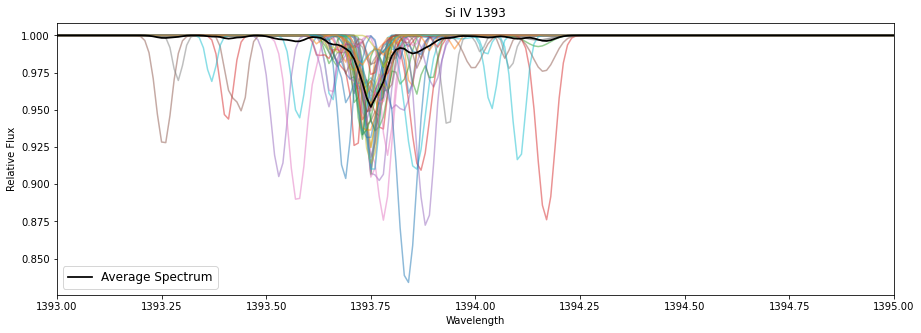

In [44]:
si1393_b = spec_avg(.125,.27,.495,.125,.44,.495, 21, 2,
                    'Si IV 1393', 'Si', 'IV', 1393, 1395, 1393.76, 9.0E+8, 5.24E-01, 28.08,
                    DIY=True, ind_p=True)

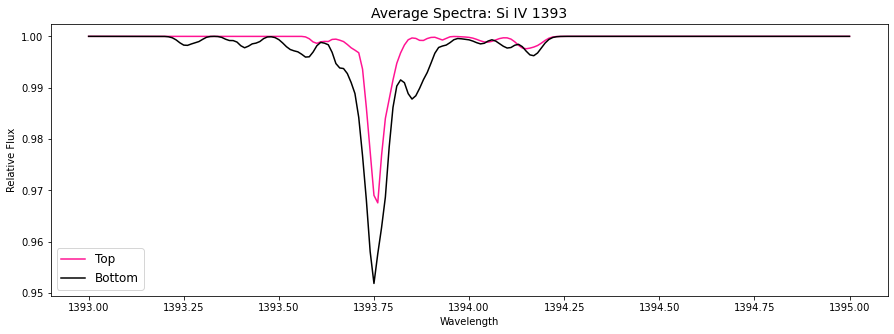

In [45]:
compare(si1393_t[0], si1393_t[1], si1393_b[0], si1393_b[1], ' Si IV 1393')

## Al III 1854

yt : [INFO     ] 2021-12-02 13:25:16,153 Getting segment at z = 0.0: [0.135  0.309  0.2475] unitary to [0.135  0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:25:16,155 Getting subsegment: [0.135 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.135 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:25:17,273 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:25:17,398 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:25:17,399 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:25:17,400 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:25:17,401 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] c

yt : [INFO     ] 2021-12-02 13:25:24,542 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:25:24,543 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:25:24,544 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:25:24,545 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:25:24,547 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:25:24,560 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:25:24,566 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:25:24,700 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:25:24,706 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1776.01it/s]
yt : [INFO     ] 2021-12-02 13:25:24,769 Writing spectrum to ascii file: spec.txt.
yt

yt : [INFO     ] 2021-12-02 13:25:31,863 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:25:31,870 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1348.57it/s]
yt : [INFO     ] 2021-12-02 13:25:31,945 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:25:31,961 Getting segment at z = 0.0: [0.14476563 0.309      0.24945312] unitary to [0.14476563 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:25:31,963 Getting subsegment: [0.144765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.144765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:25:33,125 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:25:33,256 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:25:33,257 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:25:33,257 

yt : [INFO     ] 2021-12-02 13:25:40,638 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:25:40,775 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:25:40,776 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:25:40,777 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:25:40,779 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:25:40,780 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:25:40,783 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:25:40,800 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:25:40,806 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:25:41,092 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:25:41,099 Creating spectrum
Add

yt : [INFO     ] 2021-12-02 13:25:48,155 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:25:48,161 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:25:48,298 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:25:48,304 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1724.67it/s]
yt : [INFO     ] 2021-12-02 13:25:48,364 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:25:48,379 Getting segment at z = 0.0: [0.15648438 0.309      0.2475    ] unitary to [0.15648438 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:25:48,381 Getting subsegment: [0.156484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.156484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:25:49,373 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:25:49,4

yt : [INFO     ] 2021-12-02 13:25:55,310 Getting subsegment: [0.160390625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.160390625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:25:56,330 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:25:56,443 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:25:56,444 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:25:56,445 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:25:56,446 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:25:56,446 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:25:56,449 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:25:56,466 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:25:56,474 Identified 2.500e+01 octs

yt : [INFO     ] 2021-12-02 13:26:03,277 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:26:03,281 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:26:03,297 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:26:03,302 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:26:03,560 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:26:03,567 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1817.24it/s]
yt : [INFO     ] 2021-12-02 13:26:03,629 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:26:03,645 Getting segment at z = 0.0: [0.16625    0.309      0.24945312] unitary to [0.16625    0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:26:03,647 Getting subsegment: [0.16625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.16625 unitary, 0.34 unitary, 0.249453125

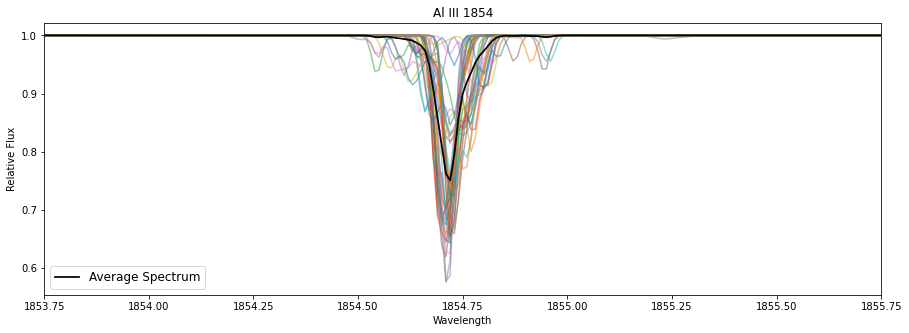

In [46]:
al1854_t = spec_avg(.27,.618,.495,.27,.68,.495, 21, 2,
                    'Al III 1854', 'Al', 'III', 1853.75, 1855.75, 1854.72, 5.57E+08, 5.75E-01, 26.98,
                    DIY=True, ind_p=True)

yt : [INFO     ] 2021-12-02 13:26:15,945 Getting segment at z = 0.0: [0.0625 0.135  0.2475] unitary to [0.0625 0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:26:15,948 Getting subsegment: [0.0625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.0625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:26:16,956 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:26:17,079 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:26:17,080 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:26:17,081 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:26:17,082 Parameters: domain_right_edge         = [6.172e+22 3.086

yt : [INFO     ] 2021-12-02 13:26:23,829 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:26:23,950 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:26:23,951 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:26:23,952 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:26:23,953 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:26:23,954 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:26:23,956 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:26:23,972 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:26:23,978 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:26:24,117 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:26:24,122 Creating spectrum
Add

yt : [INFO     ] 2021-12-02 13:26:30,888 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:26:30,907 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:26:30,913 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:26:31,052 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:26:31,057 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2744.19it/s]
yt : [INFO     ] 2021-12-02 13:26:31,127 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:26:31,142 Getting segment at z = 0.0: [0.07226562 0.135      0.24945312] unitary to [0.07226562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:26:31,144 Getting subsegment: [0.072265625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.072265625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:26:32,122 Saving fie

yt : [INFO     ] 2021-12-02 13:26:38,018 Getting segment at z = 0.0: [0.078125 0.135    0.2475  ] unitary to [0.078125 0.22     0.2475  ] unitary.
yt : [INFO     ] 2021-12-02 13:26:38,020 Getting subsegment: [0.078125 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.078125 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:26:39,010 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:26:39,122 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:26:39,123 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:26:39,124 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:26:39,125 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:26:39,125 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:26:39,128 Setting instrument to Custo

yt : [INFO     ] 2021-12-02 13:26:45,876 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:26:45,877 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:26:45,878 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:26:45,879 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:26:45,881 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:26:45,894 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:26:45,900 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:26:46,030 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:26:46,036 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2759.33it/s]
yt : [INFO     ] 2021-12-02 13:26:46,104 Writing spectrum to ascii file: spec.txt.
yt

yt : [INFO     ] 2021-12-02 13:26:52,809 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:26:52,943 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:26:52,948 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2853.40it/s]
yt : [INFO     ] 2021-12-02 13:26:53,019 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:26:53,033 Getting segment at z = 0.0: [0.08789062 0.135      0.24945312] unitary to [0.08789062 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:26:53,035 Getting subsegment: [0.087890625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.087890625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:26:54,019 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:26:54,137 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:26:54,138 Paramet

yt : [INFO     ] 2021-12-02 13:26:59,904 Getting subsegment: [0.09375 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.09375 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:27:00,912 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:27:01,024 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:27:01,025 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:27:01,026 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:27:01,027 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:27:01,028 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:27:01,031 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:27:01,048 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:27:01,056 Id

yt : [INFO     ] 2021-12-02 13:27:07,883 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:27:07,884 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:27:07,886 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:27:07,901 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:27:07,907 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:27:08,042 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:27:08,049 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 44/44 [00:00<00:00, 3559.64it/s]
yt : [INFO     ] 2021-12-02 13:27:08,112 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:27:08,127 Getting segment at z = 0.0: [0.09960938 0.135      0.2475    ] unitary to [0.09960938 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:27:08

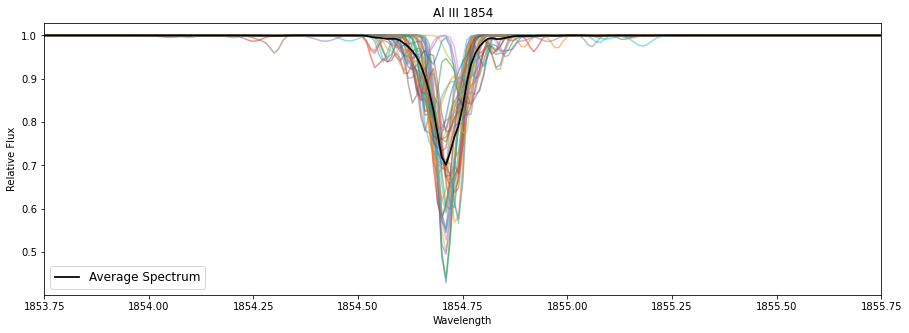

In [47]:
al1854_b = spec_avg(.125,.27,.495,.125,.44,.495, 21, 2,
                    'Al III 1854', 'Al', 'III', 1853.75, 1855.75, 1854.72, 5.57E+08, 5.75E-01, 26.98,
                    DIY=True, ind_p=True)

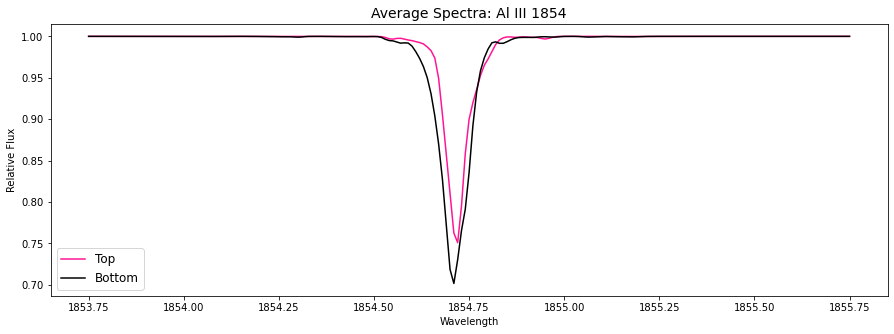

In [48]:
compare(al1854_t[0], al1854_t[1], al1854_b[0], al1854_b[1], ' Al III 1854')

## Fe II 2600

yt : [INFO     ] 2021-12-02 13:29:42,508 Getting segment at z = 0.0: [0.135  0.309  0.2475] unitary to [0.135  0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:29:42,511 Getting subsegment: [0.135 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.135 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:29:43,483 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:29:43,610 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:29:43,610 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:29:43,611 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:29:43,612 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] c

yt : [INFO     ] 2021-12-02 13:29:51,518 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:29:51,519 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:29:51,520 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:29:51,520 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:29:51,522 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:29:51,536 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:29:51,542 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:29:51,709 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:29:51,714 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1151.52it/s]
yt : [INFO     ] 2021-12-02 13:29:51,790 Writing spectrum to ascii file: spec.txt.
yt 

yt : [INFO     ] 2021-12-02 13:29:59,157 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:29:59,162 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1048.30it/s]
yt : [INFO     ] 2021-12-02 13:29:59,233 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:29:59,249 Getting segment at z = 0.0: [0.14476563 0.309      0.24945312] unitary to [0.14476563 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:29:59,251 Getting subsegment: [0.144765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.144765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:30:00,299 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:30:00,415 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:30:00,416 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:30:00,417 P

yt : [INFO     ] 2021-12-02 13:30:07,342 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:30:07,459 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:30:07,460 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:30:07,461 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:30:07,462 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:30:07,463 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:30:07,465 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:30:07,483 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:30:07,489 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:30:07,624 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:30:07,630 Creating spectrum
Add

yt : [INFO     ] 2021-12-02 13:30:14,346 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:30:14,352 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:30:14,490 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:30:14,496 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1249.81it/s]
yt : [INFO     ] 2021-12-02 13:30:14,563 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:30:14,579 Getting segment at z = 0.0: [0.15648438 0.309      0.2475    ] unitary to [0.15648438 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:30:14,582 Getting subsegment: [0.156484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.156484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:30:15,616 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:30:15,73

yt : [INFO     ] 2021-12-02 13:30:21,482 Getting subsegment: [0.160390625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.160390625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:30:22,466 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:30:22,580 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:30:22,581 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:30:22,582 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:30:22,583 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:30:22,584 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:30:22,587 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:30:22,605 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:30:22,612 Identified 2.500e+01 octs

yt : [INFO     ] 2021-12-02 13:30:29,519 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:30:29,522 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:30:29,537 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:30:29,544 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:30:29,680 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:30:29,685 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1291.70it/s]
yt : [INFO     ] 2021-12-02 13:30:29,750 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:30:29,768 Getting segment at z = 0.0: [0.16625    0.309      0.24945312] unitary to [0.16625    0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:30:29,771 Getting subsegment: [0.16625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.16625 unitary, 0.34 unitary, 0.249453125 

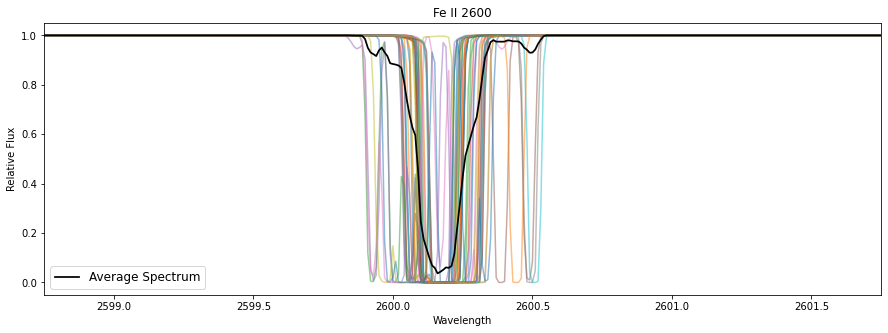

In [49]:
fe26_t = spec_avg(.27,.618,.495,.27,.68,.495, 21, 2,
                  'Fe II 2600', 'Fe', 'II', 2598.75, 2601.75, 2600.17, 2.37E+08, 2.4E-01, 55.85,
                  DIY=True, ind_p=True)

yt : [INFO     ] 2021-12-02 13:30:42,333 Getting segment at z = 0.0: [0.0625 0.135  0.2475] unitary to [0.0625 0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:30:42,335 Getting subsegment: [0.0625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.0625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:30:43,324 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:30:43,446 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:30:43,447 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:30:43,447 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:30:43,448 Parameters: domain_right_edge         = [6.172e+22 3.086

yt : [INFO     ] 2021-12-02 13:30:50,479 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:30:50,480 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:30:50,481 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:30:50,482 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:30:50,482 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:30:50,485 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:30:50,499 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:30:50,509 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:30:50,648 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:30:50,653 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1589

yt : [INFO     ] 2021-12-02 13:30:57,468 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:30:57,474 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:30:57,623 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:30:57,628 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1975.56it/s]
yt : [INFO     ] 2021-12-02 13:30:57,702 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:30:57,721 Getting segment at z = 0.0: [0.07226562 0.135      0.24945312] unitary to [0.07226562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:30:57,724 Getting subsegment: [0.072265625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.072265625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:30:58,762 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:30:58,886

yt : [INFO     ] 2021-12-02 13:31:04,836 Getting subsegment: [0.078125 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.078125 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:31:05,843 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:31:05,960 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:31:05,961 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:31:05,962 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:31:05,963 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:31:05,964 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:31:05,966 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:31:05,981 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:31:05,991 

yt : [INFO     ] 2021-12-02 13:31:13,617 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:31:13,618 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:31:13,620 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:31:13,635 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:31:13,641 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:31:13,773 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:31:13,780 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2021.51it/s]
yt : [INFO     ] 2021-12-02 13:31:13,853 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:31:13,869 Getting segment at z = 0.0: [0.08398438 0.135      0.2475    ] unitary to [0.08398438 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:31:13,

yt : [INFO     ] 2021-12-02 13:31:20,738 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2251.43it/s]
yt : [INFO     ] 2021-12-02 13:31:20,818 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:31:20,835 Getting segment at z = 0.0: [0.08789062 0.135      0.24945312] unitary to [0.08789062 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:31:20,838 Getting subsegment: [0.087890625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.087890625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:31:21,827 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:31:21,946 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:31:21,946 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:31:21,947 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:31:21,950

yt : [INFO     ] 2021-12-02 13:31:28,879 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:31:28,998 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:31:28,999 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:31:29,000 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:31:29,001 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:31:29,002 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:31:29,004 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:31:29,018 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:31:29,026 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:31:29,161 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:31:29,167 Creating spectrum
Add

yt : [INFO     ] 2021-12-02 13:31:35,871 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:31:35,885 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:31:35,890 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:31:36,025 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:31:36,030 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2372.98it/s]
yt : [INFO     ] 2021-12-02 13:31:36,102 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:31:36,119 Getting segment at z = 0.0: [0.09960938 0.135      0.2475    ] unitary to [0.09960938 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:31:36,122 Getting subsegment: [0.099609375 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.099609375 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:31:37

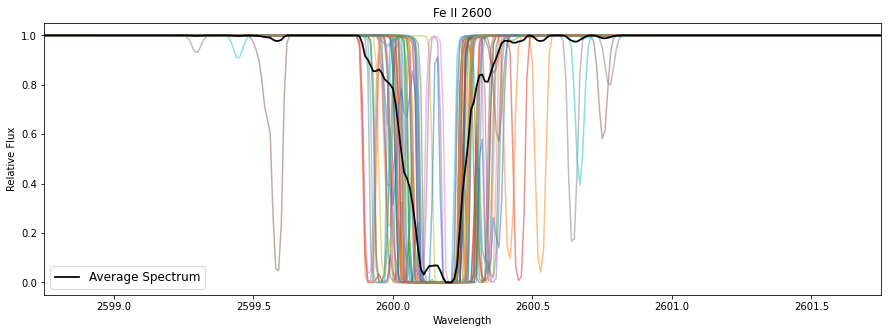

In [50]:
fe26_b = spec_avg(.125,.27,.495,.125,.44,.495, 21, 2,
                  'Fe II 2600', 'Fe', 'II', 2598.75, 2601.75, 2600.17, 2.37E+08, 2.4E-01, 55.85,
                  DIY=True, ind_p=True)

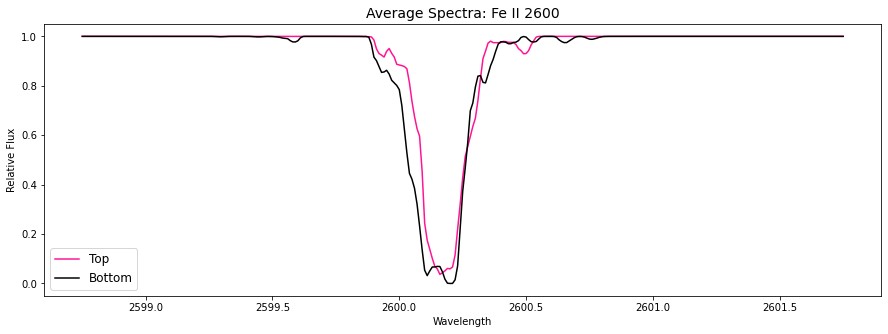

In [51]:
compare(fe26_t[0], fe26_t[1], fe26_b[0], fe26_b[1], ' Fe II 2600')

## Mg II 2796

yt : [INFO     ] 2021-12-02 13:32:20,564 Getting segment at z = 0.0: [0.135  0.309  0.2475] unitary to [0.135  0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:32:20,567 Getting subsegment: [0.135 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.135 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:32:21,684 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:32:21,835 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:32:21,836 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:32:21,837 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:32:21,838 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] c

yt : [INFO     ] 2021-12-02 13:32:29,753 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:32:29,754 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:32:29,755 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:32:29,756 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:32:29,758 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:32:29,771 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:32:29,777 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:32:29,966 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:32:29,972 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 622.07it/s]
yt : [INFO     ] 2021-12-02 13:32:30,064 Writing spectrum to ascii file: spec.txt.
yt :

yt : [INFO     ] 2021-12-02 13:32:37,380 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:32:37,385 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 640.44it/s]
yt : [INFO     ] 2021-12-02 13:32:37,476 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:32:37,495 Getting segment at z = 0.0: [0.14476563 0.309      0.24945312] unitary to [0.14476563 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:32:37,497 Getting subsegment: [0.144765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.144765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:32:38,611 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:32:38,728 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:32:38,729 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:32:38,730 Pa

yt : [INFO     ] 2021-12-02 13:32:46,006 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:32:46,123 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:32:46,124 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:32:46,124 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:32:46,125 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:32:46,126 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:32:46,128 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:32:46,145 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:32:46,152 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:32:46,285 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:32:46,290 Creating spectrum
Add

yt : [INFO     ] 2021-12-02 13:32:53,066 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:32:53,071 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:32:53,207 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:32:53,212 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 905.85it/s]
yt : [INFO     ] 2021-12-02 13:32:53,282 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:32:53,298 Getting segment at z = 0.0: [0.15648438 0.309      0.2475    ] unitary to [0.15648438 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:32:53,300 Getting subsegment: [0.156484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.156484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:32:54,304 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:32:54,418

yt : [INFO     ] 2021-12-02 13:33:00,317 Getting subsegment: [0.160390625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.160390625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:33:01,321 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:33:01,438 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:33:01,439 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:33:01,439 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:33:01,441 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:33:01,441 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:33:01,444 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:33:01,459 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:33:01,467 Identified 2.500e+01 octs

yt : [INFO     ] 2021-12-02 13:33:08,536 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:33:08,539 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:33:08,553 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:33:08,559 Identified 2.500e+01 octs
yt : [INFO     ] 2021-12-02 13:33:08,690 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:33:08,695 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 882.57it/s]
yt : [INFO     ] 2021-12-02 13:33:08,765 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:33:08,782 Getting segment at z = 0.0: [0.16625    0.309      0.24945312] unitary to [0.16625    0.34       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:33:08,784 Getting subsegment: [0.16625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.16625 unitary, 0.34 unitary, 0.249453125 u

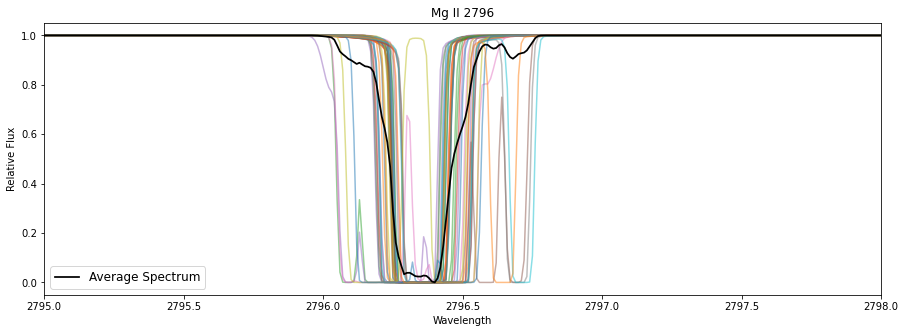

In [52]:
mg27_t = spec_avg(.27,.618,.495,.27,.68,.495, 21, 2,
                  'Mg II 2796', 'Mg', 'II', 2795, 2798, 2796.35, 2.68E+08, 6.29E-01, 24.31,
                  DIY=True, ind_p=True)

yt : [INFO     ] 2021-12-02 13:33:21,496 Getting segment at z = 0.0: [0.0625 0.135  0.2475] unitary to [0.0625 0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-12-02 13:33:21,498 Getting subsegment: [0.0625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.0625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:33:22,486 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:33:22,607 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:33:22,608 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:33:22,608 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:33:22,609 Parameters: domain_right_edge         = [6.172e+22 3.086

yt : [INFO     ] 2021-12-02 13:33:29,714 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:33:29,715 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:33:29,715 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:33:29,716 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:33:29,717 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:33:29,719 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:33:29,735 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:33:29,741 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:33:29,883 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:33:29,889 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1103

yt : [INFO     ] 2021-12-02 13:33:36,903 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:33:36,909 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:33:37,042 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:33:37,047 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1505.10it/s]
yt : [INFO     ] 2021-12-02 13:33:37,131 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:33:37,149 Getting segment at z = 0.0: [0.07226562 0.135      0.24945312] unitary to [0.07226562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:33:37,151 Getting subsegment: [0.072265625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.072265625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:33:38,190 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:33:38,306

yt : [INFO     ] 2021-12-02 13:33:44,347 Getting subsegment: [0.078125 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.078125 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:33:45,375 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:33:45,492 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:33:45,493 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:33:45,494 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:33:45,495 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:33:45,496 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:33:45,498 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:33:45,515 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:33:45,521 

yt : [INFO     ] 2021-12-02 13:33:52,475 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:33:52,476 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:33:52,478 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:33:52,494 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:33:52,501 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:33:52,636 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:33:52,641 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1498.12it/s]
yt : [INFO     ] 2021-12-02 13:33:52,722 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:33:52,740 Getting segment at z = 0.0: [0.08398438 0.135      0.2475    ] unitary to [0.08398438 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:33:52,

yt : [INFO     ] 2021-12-02 13:34:00,002 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1476.06it/s]
yt : [INFO     ] 2021-12-02 13:34:00,083 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:34:00,103 Getting segment at z = 0.0: [0.08789062 0.135      0.24945312] unitary to [0.08789062 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-12-02 13:34:00,106 Getting subsegment: [0.087890625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.087890625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-12-02 13:34:01,126 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:34:01,239 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:34:01,240 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:34:01,241 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:34:01,241

yt : [INFO     ] 2021-12-02 13:34:08,116 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-12-02 13:34:08,232 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-12-02 13:34:08,233 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-12-02 13:34:08,234 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-12-02 13:34:08,235 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-12-02 13:34:08,236 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-12-02 13:34:08,238 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:34:08,253 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:34:08,260 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:34:08,391 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:34:08,396 Creating spectrum
Add

yt : [INFO     ] 2021-12-02 13:34:15,404 Setting instrument to Custom
yt : [INFO     ] 2021-12-02 13:34:15,424 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-12-02 13:34:15,433 Identified 4.100e+01 octs
yt : [INFO     ] 2021-12-02 13:34:15,590 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-12-02 13:34:15,596 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 44/44 [00:00<00:00, 1748.54it/s]
yt : [INFO     ] 2021-12-02 13:34:15,674 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-12-02 13:34:15,692 Getting segment at z = 0.0: [0.09960938 0.135      0.2475    ] unitary to [0.09960938 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-12-02 13:34:15,694 Getting subsegment: [0.099609375 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.099609375 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-12-02 13:34:16

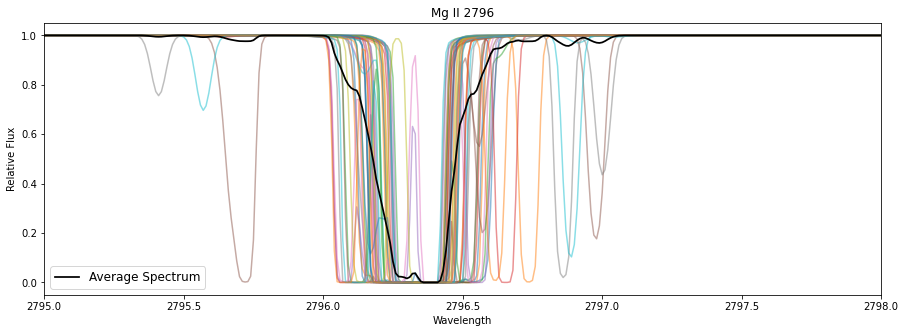

In [53]:
mg27_b = spec_avg(.125,.27,.495,.125,.44,.495, 21, 2,
                  'Mg II 2796', 'Mg', 'II', 2795, 2798, 2796.35, 2.68E+08, 6.29E-01, 24.31,
                  DIY=True, ind_p=True)

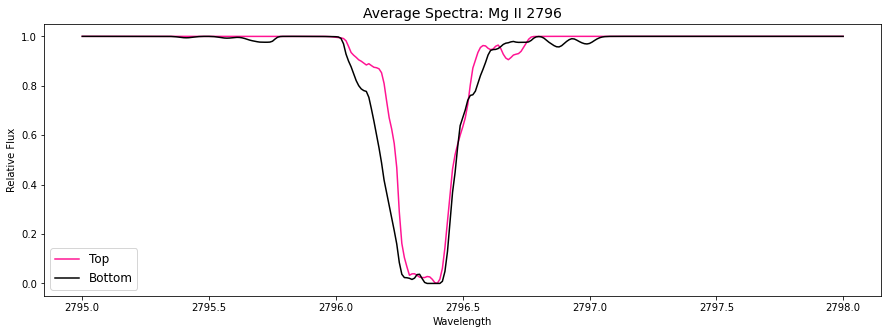

In [54]:
compare(mg27_t[0], mg27_t[1], mg27_b[0], mg27_b[1], ' Mg II 2796')